# This notebook is a test bench for working on the core model

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import torch
import numpy as np
from torch import nn

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster.k_means_ import _k_init
from sklearn.utils.extmath import row_norms
from sklearn.datasets import fetch_20newsgroups

from tqdm import tqdm
from copy import deepcopy
from dataclasses import dataclass
from typing import List, Dict

from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import gc

/home/keller/.conda/envs/clustering/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [4]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [5]:
def lp_distance(X, Y, p=2):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [6]:
def cosine_distance(X, Y):
    """
    Computes the rowwise cosine distance between matrices X and Y.
    """
    dots = torch.stack([torch.dot(xi, yi) for xi, yi in zip(X, Y)])
    norms = torch.stack([torch.dot(xi.unsqueeze(0), yi.unsqueeze(0)) for xi, yi in zip(torch.norm(X, dim=1), torch.norm(Y, dim=1))])
    cos_sim = torch.div(dots, norms)
    return 1.0 - cos_sim

In [7]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [8]:
def mean_sparsity(X):
    """
    Computes the mean of the row-wise sparsity of the input feature-matrix X
    """
    return np.mean(np.count_nonzero(X, axis=1) / X.shape[1])

In [9]:
from dataclasses import dataclass
from transformers.file_utils import ModelOutput

@dataclass
class ClusterOutput(ModelOutput):
    
    loss: torch.FloatTensor = None
    predicted_labels: torch.IntTensor = None
    embeddings: torch.FloatTensor = None

In [10]:
def cls_embedding_extractor(model_output: ModelOutput):
    return model_output.last_hidden_state[:, 0, :].float()

def meanpooler_embedding_extractor(model_ouput: ModelOutput):
    return model_ouput.last_hidden_state.mean(dim=1).float()

def concat_cls_n_hidden_states(model_output: ModelOutput, n=5):
    n_hidden_states = model_output.hidden_states[-n:]
    return torch.cat([t[:, 0, :] for t in n_hidden_states], 1).float()

def concat_mean_n_hidden_states(model_output: ModelOutput, n=3):
    n_hidden_states = model_output.hidden_states[-n:]    
    return torch.cat([t.mean(dim=1) for t in n_hidden_states], 1).float()

class LearnableWeightedAverage(nn.Module):

    def __init__(self, n=3, device='cuda:0'):
        super(LearnableWeightedAverage, self).__init__()
        self.n = n
        self.device = device
        self.register_parameter(
            'weights',
            nn.Parameter(torch.ones(self.n).float().unsqueeze(1), requires_grad=True)
        )
        self.tanh = nn.Tanh()

        self.to(self.device)

    def __forward__(self, model_output: ModelOutput):
        n_hidden_states = model_output.hidden_states[-self.n:]
        stacked_cls = torch.cat([t[:, 0, :] for t in n_hidden_states], 0).reshape(-1, self.n, 768)
        return (stacked_cls * self.tanh(self.weights)).mean(dim=1)

    def __call__(self, *args, **kwargs):
        return self.__forward__(*args, **kwargs)

class Projection(nn.Module):

    def __init__(self, n=6, out_features=768, device='cuda:0'):
        super(Projection, self).__init__()
        self.n = n
        self.device = device
        self.out_features = out_features
        self.linear = nn.Linear(in_features=self.n*768, out_features=768)
        self.linear2 = nn.Linear(in_features=768, out_features=self.out_features)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.to(self.device)

    def __forward__(self, model_output: ModelOutput):
        concatenated = concat_cls_n_hidden_states(model_output=model_output, n=self.n)
        return self.tanh(self.linear2(self.relu(self.linear(concatenated))))

    def __call__(self, *args, **kwargs):
        return self.__forward__(*args, **kwargs)

In [11]:
class ClusterLM(nn.Module):

    def __init__(self,
                 initial_centroids: torch.tensor,
                 lm_model,
                 tokenizer,
                 metric=lp_distance,
                 embedding_extractor=cls_embedding_extractor,
                 do_language_modeling=True,
                 device='cpu'
                 ):
        super(ClusterLM, self).__init__()

        self.initial_centroids = initial_centroids

        self.add_module('lm_model', lm_model)
        self.register_parameter('centroids', nn.Parameter(initial_centroids.clone().float(), requires_grad=True))

        self.tokenizer = tokenizer
        self.metric = metric
        self.embedding_extractor = embedding_extractor
        self.do_language_modeling = do_language_modeling
        self.device = device

        self.to(self.device)

    def forward(self, texts, alpha=1.0):
        """
        Input: texts and labels (optional)
        Returns: lm_language modelling output, own output dict (clustering_loss, predicted_labels)
        """
        # Language Modeling Part:

        lm_outputs = ModelOutput(loss=torch.tensor(0.0, requires_grad=True).to(self.device))

        if self.do_language_modeling:
            inputs = self.tokenizer(
                texts,
                return_tensors='pt',
                padding=True,
                truncation=True)

            input_ids = inputs['input_ids'].clone()
            input_ids, true_ids = mask_tokens(input_ids, self.tokenizer)
            inputs['input_ids'] = input_ids

            inputs = inputs.to(self.device)
            true_ids = true_ids.to(self.device)
            lm_outputs = self.lm_model(labels=true_ids, **inputs)

        # Clustering Part:
        inputs = self.tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
            truncation=True)

        inputs.to(self.device)

        # 0. Obtain embeddings for each input
        input_embeddings = self.embedding_extractor(self.lm_model.base_model(**inputs))
        #input_embeddings = input_embeddings / torch.norm(input_embeddings, dim=0)
        
        # 1. Compute distances from each input embedding to each centroids
        distances = torch.stack([self.metric(embedding.unsqueeze(0), self.centroids) for embedding in input_embeddings])
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)  # => shape (n_centroids, n_samples)

        # 2. Compute the paramterized softmin for each centroid of each distance to each centroid per input sample
        # Find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        # Compute exponetials
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        # Compute softmin
        softmin = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. Weight the distance between each sample and each centroid
        weighted_distances = distances * softmin

        # 4. Sum over weighted_distances to obtain loss
        clustering_loss = weighted_distances.sum(dim=1).mean()

        # Create clustering output dictionary
        cluster_outputs = ClusterOutput(
            loss=clustering_loss,
            predicted_labels=nearest_centroids.long(),
            embeddings=input_embeddings.cpu().detach()
        )

        return lm_outputs, cluster_outputs


In [12]:
def init_model(
    lm_model,
    tokenizer,
    data_loader,
    n_clusters,
    embedding_extractor=concat_cls_n_hidden_states,
    device='cpu',
    random_state=np.random.RandomState(42),
    **kwargs,
):
    
    initial_embeddings = []
    for batch_texts, _ in data_loader:
        inputs = tokenizer(list(batch_texts), return_tensors='pt', padding=True, truncation=True)
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = lm_model.base_model(**inputs)
        extracted_embeddings = embedding_extractor(outputs).cpu().detach().numpy()
        initial_embeddings.append(extracted_embeddings)
        
    initial_embeddings = np.vstack(initial_embeddings)
    
    
    initial_centroids = _k_init(
        initial_embeddings,
        n_clusters=np.unique(labels).shape[0],
        x_squared_norms=row_norms(initial_embeddings, squared=True),
        random_state=np.random.RandomState(42)
    )
    
    model = ClusterLM(
        lm_model=lm_model,
        tokenizer=tokenizer,
        embedding_extractor=embedding_extractor,
        initial_centroids=torch.from_numpy(initial_centroids),
        device=device,
        **kwargs
    )
    
    return model, initial_centroids, initial_embeddings

In [13]:
def evaluate(model, eval_data_loader, verbose=True):
    model.eval()
    true_labels = []
    predicted_labels = []
    eval_data_it = tqdm(eval_data_loader, desc='Eval') if verbose else eval_data_loader
    for batch_texts, batch_labels in eval_data_it:
        true_labels.extend(batch_labels.numpy().astype('int'))
        with torch.no_grad():
            _, cluster_outputs = model(texts=list(batch_texts))
        predicted_labels.extend(cluster_outputs.predicted_labels.numpy().astype('int'))
    
    return np.array(predicted_labels), np.array(true_labels)

In [14]:
@dataclass
class TrainHistory:
    clustering_losses: List[float] 
    lm_losses: List[float]
    combined_losses: List[float]
    prediction_history: List[np.array]
    eval_hist: List[Dict[str, float]]
    

In [15]:
def train(
    n_epochs,
    model,
    optimizer,
    scheduler,
    annealing_alphas,
    train_data_loader,
    eval_data_loader=None,
    do_eval=True,
    clustering_loss_weight=0.5,
    metrics=(cluster_accuracy, adjusted_rand_score, normalized_mutual_info_score),
    verbose=True
):
    
    total_clustering_losses = []
    total_lm_losses = []
    total_combined_losses = []
    prediction_history = []
    eval_hist = []
    
    assert len(annealing_alphas) >= n_epochs
    for epoch, alpha in zip(range(n_epochs), annealing_alphas):
        model.train()
        train_data_it = tqdm(train_data_loader, desc='Train') if verbose else train_data_loader
        for batch_texts, _ in train_data_it:
            lm_outputs, cluster_outputs = model(texts=list(batch_texts), alpha=alpha)
            combined_loss = ((1- clustering_loss_weight) * lm_outputs.loss) + (clustering_loss_weight * cluster_outputs.loss)
            
        
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_clustering_losses.append(cluster_outputs.loss.item())
            total_lm_losses.append(lm_outputs.loss.item())
            total_combined_losses.append(combined_loss.item())
            
            if verbose:
                train_data_it.set_description(
                    f'Epoch: {epoch} | CombLoss: {combined_loss.item()} |LMLoss: {lm_outputs.loss.item()} | ' \
                    f' ClusterLoss: {cluster_outputs.loss.item()} | LR: {scheduler.get_last_lr()[0]} | Alpha: {alpha}'
                )
            
            
        if do_eval:
            if eval_data_loader is None:
                eval_data_loader = train_data_it if not verbose else train_data_it.iterable
            
            predicted_labels, true_labels = evaluate(
                model=model,
                eval_data_loader=eval_data_loader,
                verbose=verbose)
            
            prediction_history.append(deepcopy(predicted_labels))
            
            m = {}
            for metric in metrics:
                value = metric(true_labels, predicted_labels)
                m[metric.__name__] = value
                print(f'{metric.__name__}: {value}')
            eval_hist.append(m)
    
    train_history = TrainHistory(
        clustering_losses=total_clustering_losses,
        lm_losses=total_lm_losses,
        combined_losses=total_combined_losses,
        prediction_history=prediction_history,
        eval_hist=eval_hist
    )
    return train_history    

In [16]:
#def train(
#    n_epochs,
#    model,
#    optimizer,
#    scheduler,
#    annealing_alphas,
#    train_data_loader,
#    eval_data_loader=None,
#    do_eval=True,
#    clustering_loss_weight=0.5,
#    metrics=(cluster_accuracy, adjusted_rand_score, normalized_mutual_info_score),
#    verbose=True
#):
#    
#    total_clustering_losses = []
#    total_lm_losses = []
#    total_combined_losses = []
#    prediction_history = []
#    eval_hist = []
#    
#    assert len(annealing_alphas) >= n_epochs
#    for epoch, alpha in zip(range(n_epochs), annealing_alphas):
#        model.train()
#        train_data_it = tqdm(train_data_loader, desc='Train') if verbose else train_data_loader
#        for batch_idx, (batch_texts, _) in enumerate(train_data_it):
#            lm_outputs, cluster_outputs = model(texts=list(batch_texts), alpha=alpha)
#            #combined_loss = lm_outputs.loss + (clustering_loss_weight * cluster_outputs.loss)
#            combined_loss = ((1- clustering_loss_weight) * lm_outputs.loss) + (clustering_loss_weight * cluster_outputs.loss)
#            
#            combined_loss = combined_loss / 16
#            combined_loss.backward()
#            
#            if (batch_idx+1) % 16 == 0:
#                optimizer.step()
#                optimizer.zero_grad()
#                scheduler.step()
#            
#            total_clustering_losses.append(cluster_outputs.loss.item())
#            total_lm_losses.append(lm_outputs.loss.item())
#            total_combined_losses.append(combined_loss.item())
#            
#            if verbose:
#                train_data_it.set_description(
#                    f'Epoch: {epoch} | CombLoss: {combined_loss.item()} |LMLoss: {lm_outputs.loss.item()} | ' \
#                    f' ClusterLoss: {cluster_outputs.loss.item()} | LR: {scheduler.get_last_lr()[0]} | Alpha: {alpha}'
#                )
#            
#            
#        if do_eval:
#            if eval_data_loader is None:
#                eval_data_loader = train_data_it if not verbose else train_data_it.iterable
#            
#            predicted_labels, true_labels = evaluate(
#                model=model,
#                eval_data_loader=eval_data_loader,
#                verbose=verbose)
#            
#            prediction_history.append(deepcopy(predicted_labels))
#            
#            m = {}
#            for metric in metrics:
#                value = metric(true_labels, predicted_labels)
#                m[metric.__name__] = value
#                print(f'{metric.__name__}: {value}')
#            eval_hist.append(m)
#    
#    train_history = TrainHistory(
#        clustering_losses=total_clustering_losses,
#        lm_losses=total_lm_losses,
#        combined_losses=total_combined_losses,
#        prediction_history=prediction_history,
#        eval_hist=eval_hist
#    )
#    return train_history    

In [17]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [18]:
# Test params 
from functools import partial
N_EPOCHS = 8
DEVICE = 'cuda:0'

EMBEDDING_EXTRACTOR = partial(concat_mean_n_hidden_states, n=2)

In [19]:
import nltk

data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'misc.forsale'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)

orig_texts = np.array(data.data)
orig_labels = np.array(data.target)

#to_remove = set("#<>-|")
#orig_texts = ["".join([char for char in text if char not in to_remove]) for text in orig_texts]

texts, labels = [], []
for text, label in zip(orig_texts, orig_labels):
    sents = nltk.sent_tokenize(text)
    for sent in sents:
        texts.append(sent)
        labels.append(label)

In [20]:
import pandas as pd
df = pd.read_csv('datasets/ag_news_subset5/ag_news_subset5.csv')
texts, labels = df.texts.to_numpy(), df.labels.to_numpy()

In [21]:
#df = pd.read_excel('/home/keller/Uni/Job/Avato/Textcat_Workshop/tagged_comments_anonym_200923.xlsx', engine='openpyxl')
#df = df.dropna(subset=['Sentence', 'Class'])
#df = df.query('Class != "???" and Class != "An"')
#texts, labels = df.Sentence.to_numpy(), df.Class.to_numpy()
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#labels = le.fit_transform(labels)

In [22]:
from sklearn.model_selection import train_test_split

#texts, _, labels, _ = train_test_split(texts, labels, stratify=labels, test_size=0.8, random_state=42)

In [23]:
len(texts), len(labels)

(6380, 6380)

In [24]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=8, shuffle=False) # batch size bigger => results better
# 16 for distilbert | 8 for bert-base

In [25]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
from transformers import ElectraTokenizer, ElectraForMaskedLM
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import XLNetTokenizer, XLNetLMHeadModel

import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True, output_hidden_states=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', return_dict=True, output_hidden_states=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', return_dict=True, output_hidden_states=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-large-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', return_dict=True, output_hidden_states=True)
#lm_model = RobertaForMaskedLM.from_pretrained('roberta-base', return_dict=True, output_hidden_states=True)

#tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator', return_dict=True, output_hidden_states=True)
#lm_model = ElectraForMaskedLM.from_pretrained('google/electra-base-discriminator', return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("distilroberta-base", return_dict=True, output_hidden_states=True)


#tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased", return_dict=True, output_hidden_states=True)
#lm_model = XLNetLMHeadModel.from_pretrained("xlnet-base-cased", return_dict=True, mem_len=1024, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/distilbert-base-uncased-STS-B", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/distilbert-base-uncased-STS-B", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-cased-STS-B", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/bert-base-cased-STS-B", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news")
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/bert-base-uncased-ag-news", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("allenai/news_roberta_base")
#lm_model = AutoModelForMaskedLM.from_pretrained("allenai/news_roberta_base", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small")
#lm_model = AutoModelForMaskedLM.from_pretrained("prajjwal1/bert-small", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("google/reformer-crime-and-punishment", return_dict=True, output_hidden_states=True, model_max_length=524288)
#lm_model = AutoModelForMaskedLM.from_pretrained("google/reformer-crime-and-punishment", is_decoder=False, return_dict=True, output_hidden_states=True)

lm_model.to(DEVICE)

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [26]:
constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
alphas = np.zeros(N_EPOCHS, dtype=float)
alphas[0] = 0.1
for i in range(1, N_EPOCHS):
    alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
annealing_alphas = alphas / constant_value

annealing_alphas = np.ones(N_EPOCHS) * 1000.0
#annealing_alphas = np.arange(1, N_EPOCHS+1).astype('float')
#
#annealing_alphas = [i**2 for i in range(1, N_EPOCHS//2+1)] + [1000.0]*(N_EPOCHS//2)
#
#annealing_alphas = np.arange(1, N_EPOCHS+1).astype('float')**2

In [27]:
print(annealing_alphas)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [28]:
model, initial_centroids, initial_embeddings = init_model(
    lm_model=lm_model,
    tokenizer=tokenizer,
    data_loader=data_loader,
    embedding_extractor=EMBEDDING_EXTRACTOR,
    n_clusters=np.unique(labels).shape[0],
    device=DEVICE,
    #metric=cosine_distance
)

In [29]:
from tqdm import tqdm
import numpy as np
from transformers import (
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup
)

# RMSprop
# or Adam(W)???
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=2e-5, #2e-5, 5e-7, 
    eps=1e-8,
    weight_decay=1e-5
)

total_steps = len(data_loader) * N_EPOCHS

#scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#    optimizer=opt,
#    num_warmup_steps=int(len(data_loader)*0.5),
#    num_training_steps=total_steps,
#    num_cycles=N_EPOCHS//2
#)

scheduler = get_linear_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=int(len(data_loader)*0.5),
    num_training_steps=total_steps
)


In [30]:
hist = train(
    n_epochs=N_EPOCHS,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    annealing_alphas=annealing_alphas,
    train_data_loader=data_loader,
    clustering_loss_weight=1.0,
    verbose=True
)

Epoch: 0 | CombLoss: 4.6763410568237305 |LMLoss: 6.2809858322143555 |  ClusterLoss: 4.6763410568237305 | LR: 1.866666666666667e-05 | Alpha: 1000.0: 100%|██████████| 798/798 [01:13<00:00, 10.88it/s] 
Eval: 100%|██████████| 798/798 [00:25<00:00, 31.09it/s]
Epoch: 1 | CombLoss: 2.178640365600586 |LMLoss: 7.484373569488525 |  ClusterLoss: 2.178640365600586 | LR: 1.8663324979114454e-05 | Alpha: 1000.0:   0%|          | 1/798 [00:00<01:39,  8.01it/s]

cluster_accuracy: ({0: 3, 1: 2, 2: 1, 3: 0}, 0.46551724137931033)
adjusted_rand_score: 0.2020917274004834
normalized_mutual_info_score: 0.2370312497312415


Epoch: 1 | CombLoss: 3.8264095783233643 |LMLoss: 8.03705883026123 |  ClusterLoss: 3.8264095783233643 | LR: 1.6000000000000003e-05 | Alpha: 1000.0: 100%|██████████| 798/798 [01:13<00:00, 10.92it/s]  
Eval: 100%|██████████| 798/798 [00:25<00:00, 31.30it/s]
Epoch: 2 | CombLoss: 1.3548798561096191 |LMLoss: 7.5912346839904785 |  ClusterLoss: 1.3548798561096191 | LR: 1.5996658312447788e-05 | Alpha: 1000.0:   0%|          | 1/798 [00:00<01:33,  8.54it/s]

cluster_accuracy: ({0: 3, 1: 0, 2: 1, 3: 2}, 0.45109717868338556)
adjusted_rand_score: 0.18443778433805358
normalized_mutual_info_score: 0.19028691540577214


Epoch: 2 | CombLoss: 3.21821665763855 |LMLoss: 8.73885726928711 |  ClusterLoss: 3.21821665763855 | LR: 1.3333333333333333e-05 | Alpha: 1000.0: 100%|██████████| 798/798 [01:16<00:00, 10.43it/s]      
Eval: 100%|██████████| 798/798 [00:27<00:00, 29.26it/s]
Epoch: 3 | CombLoss: 0.772739589214325 |LMLoss: 9.645251274108887 |  ClusterLoss: 0.772739589214325 | LR: 1.3329991645781119e-05 | Alpha: 1000.0:   0%|          | 1/798 [00:00<01:26,  9.23it/s]

cluster_accuracy: ({0: 3, 1: 0, 2: 1, 3: 2}, 0.45015673981191223)
adjusted_rand_score: 0.18793295540578905
normalized_mutual_info_score: 0.20372725802316935


Epoch: 3 | CombLoss: 2.842294931411743 |LMLoss: 8.560929298400879 |  ClusterLoss: 2.842294931411743 | LR: 1.0666666666666667e-05 | Alpha: 1000.0: 100%|██████████| 798/798 [01:14<00:00, 10.65it/s]   
Eval: 100%|██████████| 798/798 [00:25<00:00, 31.78it/s]
Epoch: 4 | CombLoss: 0.48894909024238586 |LMLoss: 9.525764465332031 |  ClusterLoss: 0.48894909024238586 | LR: 1.0659983291562239e-05 | Alpha: 1000.0:   0%|          | 1/798 [00:00<01:24,  9.46it/s]

cluster_accuracy: ({0: 3, 1: 2, 2: 1, 3: 0}, 0.44764890282131664)
adjusted_rand_score: 0.17225268804134622
normalized_mutual_info_score: 0.18740782456255003


Epoch: 4 | CombLoss: 2.761416435241699 |LMLoss: 8.19271469116211 |  ClusterLoss: 2.761416435241699 | LR: 8.000000000000001e-06 | Alpha: 1000.0: 100%|██████████| 798/798 [01:14<00:00, 10.73it/s]      
Eval: 100%|██████████| 798/798 [00:24<00:00, 32.80it/s]
Epoch: 5 | CombLoss: 0.5115249156951904 |LMLoss: 9.687445640563965 |  ClusterLoss: 0.5115249156951904 | LR: 7.996658312447787e-06 | Alpha: 1000.0:   0%|          | 1/798 [00:00<01:30,  8.79it/s]

cluster_accuracy: ({0: 3, 1: 2, 2: 1, 3: 0}, 0.4445141065830721)
adjusted_rand_score: 0.171814247750592
normalized_mutual_info_score: 0.18649858222490395


Epoch: 5 | CombLoss: 2.6695210933685303 |LMLoss: 10.065566062927246 |  ClusterLoss: 2.6695210933685303 | LR: 5.333333333333334e-06 | Alpha: 1000.0: 100%|██████████| 798/798 [01:14<00:00, 10.64it/s]   
Eval: 100%|██████████| 798/798 [00:25<00:00, 30.90it/s]
Epoch: 6 | CombLoss: 0.5509175062179565 |LMLoss: 9.748733520507812 |  ClusterLoss: 0.5509175062179565 | LR: 5.329991645781119e-06 | Alpha: 1000.0:   0%|          | 1/798 [00:00<01:29,  8.88it/s]

cluster_accuracy: ({0: 3, 1: 2, 2: 1, 3: 0}, 0.4443573667711599)
adjusted_rand_score: 0.17187686959711426
normalized_mutual_info_score: 0.18769673618107094


Epoch: 6 | CombLoss: 2.659360408782959 |LMLoss: 9.287376403808594 |  ClusterLoss: 2.659360408782959 | LR: 2.666666666666667e-06 | Alpha: 1000.0: 100%|██████████| 798/798 [01:16<00:00, 10.43it/s]      
Eval: 100%|██████████| 798/798 [00:27<00:00, 29.48it/s]
Epoch: 7 | CombLoss: 0.4357689619064331 |LMLoss: 11.303024291992188 |  ClusterLoss: 0.4357689619064331 | LR: 2.663324979114453e-06 | Alpha: 1000.0:   0%|          | 1/798 [00:00<01:37,  8.20it/s]

cluster_accuracy: ({0: 3, 1: 2, 2: 1, 3: 0}, 0.4426332288401254)
adjusted_rand_score: 0.17467052457576207
normalized_mutual_info_score: 0.18820608840528966


Epoch: 7 | CombLoss: 2.709764242172241 |LMLoss: 8.615718841552734 |  ClusterLoss: 2.709764242172241 | LR: 0.0 | Alpha: 1000.0: 100%|██████████| 798/798 [01:15<00:00, 10.58it/s]                        
Eval: 100%|██████████| 798/798 [00:24<00:00, 32.37it/s]

cluster_accuracy: ({0: 3, 1: 2, 2: 1, 3: 0}, 0.44404388714733545)
adjusted_rand_score: 0.1748532650581352
normalized_mutual_info_score: 0.18897543916643403


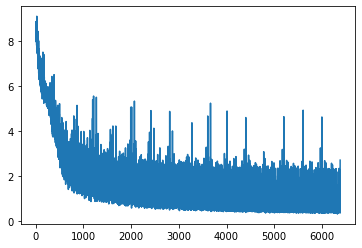

In [31]:
plt.plot(hist.clustering_losses)
plt.show()

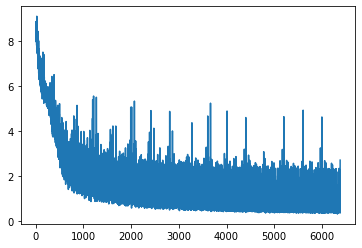

In [32]:
plt.plot(hist.combined_losses)
plt.show()

In [33]:
[i['cluster_accuracy'][0] for i in hist.eval_hist]

[{0: 3, 1: 2, 2: 1, 3: 0},
 {0: 3, 1: 0, 2: 1, 3: 2},
 {0: 3, 1: 0, 2: 1, 3: 2},
 {0: 3, 1: 2, 2: 1, 3: 0},
 {0: 3, 1: 2, 2: 1, 3: 0},
 {0: 3, 1: 2, 2: 1, 3: 0},
 {0: 3, 1: 2, 2: 1, 3: 0},
 {0: 3, 1: 2, 2: 1, 3: 0}]

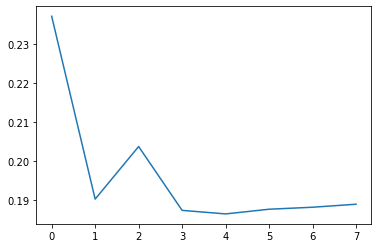

In [34]:
plt.plot([i['normalized_mutual_info_score'] for i in hist.eval_hist])
plt.show()

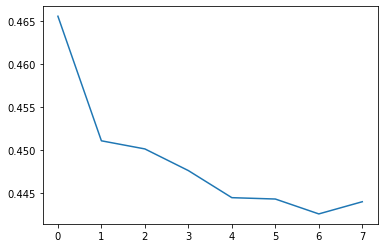

In [35]:
plt.plot([i['cluster_accuracy'][1] for i in hist.eval_hist])
plt.show()

In [36]:
import pickle
with open('train_results_test.h', 'wb') as f:
    pickle.dump(hist, file=f)

In [37]:
list(EMBEDDING_EXTRACTOR.linear.parameters())

AttributeError: 'functools.partial' object has no attribute 'linear'